
# <span style="color:rgb(213,80,0)">Multi\-shell acquisitions and MAP\-MRI</span>

This demo illustrates the basic use of the MAP\-MRI/MAPL module, aimed at the analysis of multi\-shell data sets.


In [1]:
addpath('..');
setup__DMRIMatlab_toolbox('useparallel',false); % Will be ingnored if you don't have a licensed copy of the parallel toolbox
clear;
close('all');
lambda = nan; % use GCV
tau = 36.5e-3;
ADC0 = 3.0e-3;
Nmax = 6; % Using larger Nmax will blow up computation times


















You're running version 1.0 of the toolbox under octave 10.20
Using graphics toolkit: qt








## Load data

Load first your own sutiable multi\-shell dMRI data set, which should include the attenuation signal (DWI over the averaged baseline), the mask to remove the background, the gradients table, and the b\-values for each gradient direction:


In [2]:
tic;
load test_data.mat;
T=toc; % This is always a large piece of data
fprintf(1,'It took %f seconds to load data\n',T);
whos -file test_data.mat; % Check the variables loaded, their kinds, and their sizes





It took 1.130404 seconds to load data

Variables in the file test_data.mat:

variables in scope: test_data.mat

  Attr   Name        Size                     Bytes  Class
  ====   ====        ====                     =====  ===== 
         atti      101x110x17x256         193402880  single
         bi        256x1                       2048  double
         gi        256x3                       6144  double
         mask      101x110x17                188870  logical

Total is 48540614 elements using 193599942 bytes



## Use only a few slices to accelerate the demo

In [3]:
slc = [4,9,14];
atti = atti(:,:,slc,:);
mask = mask(:,:,slc);
slc = [1,2,3];

## Compute the MAP\-MRI coefficients

The number of coefficients to fit is governed by the "Nmax" parameter. The most usual values are Nmax=4 (22 coefficients) and Nmax=6 (50 coefficients). These coefficients are fitted by solving a quadratic programming problem with a cost function that penalized both the residual of the fitting and the energy of the Laplacian of the signal (the trade\-off between the two terms is governed by the parameter "lambda"). Besides, the resulting diffusion propagator is forced to have integral one (this translates in an equality constraint over the MAP\-MRI coefficients) and to be non\-negative in a pre\-defined Cartesian grid whose density is controlled buy the parameter "constRad".


In [4]:
tic;
[mapl,dti,lopt] = atti2mapl( atti, gi, bi, 'mask', mask, ...
    'tl', 1.0e-7, 'tu', 1-1.0e-7, ... % To avoid outliers
    'Nmax', Nmax, ...
    'ADC0', ADC0, ...
    'lambda', lambda, ...
    'tau', tau, ...
    'const', true, ...
    'constRad', 7, ...  % 2*45*7+1 = 631 constraints
    'maxthreads', 8 ...
    );
fprintf(1,'It took %1.3f seconds to estimate the MAP-MRI coefficients\n',toc); % This will be a good while!













It took 32.305 seconds to estimate the MAP-MRI coefficients


## Compute some standard measures

From the MAP\-MRI coefficients, a number of popular diffusion scalar measurements can be computed, typically defined as integrals over the domain of the attenuation signal itself or its Fourier transform.


In [5]:
ng = mapl2index(mapl,dti,'mask',mask,'tau',tau,'ADC0',ADC0,'type','g');
e0 = mapl2index(mapl,dti,'mask',mask,'tau',tau,'ADC0',ADC0,'type','e');
rtop = mapl2index(mapl,dti,'mask',mask,'tau',tau,'ADC0',ADC0,'type','o');
rtap = mapl2index(mapl,dti,'mask',mask,'tau',tau,'ADC0',ADC0,'type','a');
rtpp = mapl2index(mapl,dti,'mask',mask,'tau',tau,'ADC0',ADC0,'type','p');
msd = mapl2index(mapl,dti,'mask',mask,'tau',tau,'ADC0',ADC0,'type','m');
qiv = mapl2index(mapl,dti,'mask',mask,'tau',tau,'ADC0',ADC0,'type','q');
padti = mapl2index(mapl,dti,'mask',mask,'tau',tau,'ADC0',ADC0,'type','d');
u0 = mapl2index(mapl,dti,'mask',mask,'tau',tau,'ADC0',ADC0,'type','u');
leng = mapl2index(mapl,dti,'mask',mask,'tau',tau,'ADC0',ADC0,'type','l');

## Prepare the plots

In [6]:
mapType = 'gray'; % Changing the colormap will trigger the entire demo
switch(mapType)
    case 'high'
        MAP = psychedelia(512);
    case 'gray'
        MAP = gray(512); % B/W colormap
    case 'default'
        MAP = viridis(512);
end

## Plot the results

This is what you might expect for a typical diffusion MRI volume.


















































    imshow at line 206 column 7




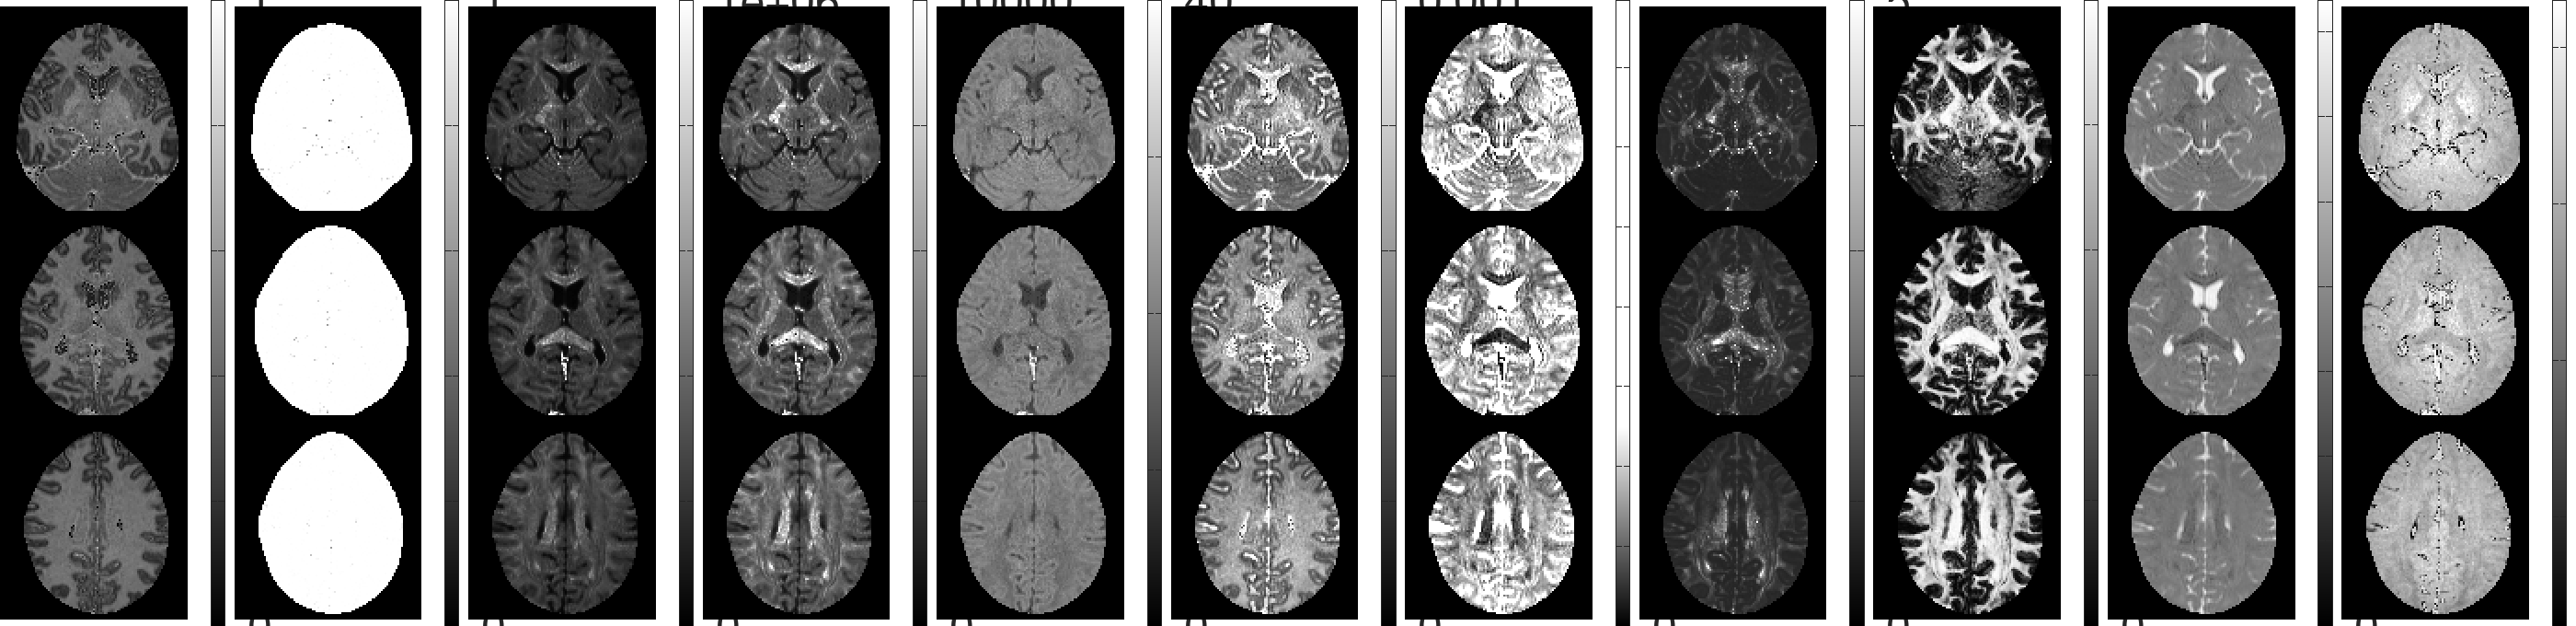

In [7]:
close(figure(1)); % Close previous figures if needed
hf = figure(1);
set(hf,'Name','MAPL indices from multi-shells','Position',[10,10,2800,680]);
R=1; C=11;
r=1; c=1; subplot('Position',[(c-1)/C,(r-1)/R,1/C,1/R]);
imshow([ng(:,:,slc(1))';ng(:,:,slc(2))';ng(:,:, ...
    slc(3))'],[0,1.0]); colormap(MAP); colorbar; title('NG');
axis('equal');axis('off');axis('tight');
r=1; c=2; subplot('Position',[(c-1)/C,(r-1)/R,1/C,1/R]);
imshow([e0(:,:,slc(1))';e0(:,:,slc(2))';e0(:,:, ...
    slc(3))'],[0,1.0]); colormap(MAP); colorbar; title('E(0)');
axis('equal');axis('off');axis('tight');
r=1; c=3; subplot('Position',[(c-1)/C,(r-1)/R,1/C,1/R]);
imshow([rtop(:,:,slc(1))';rtop(:,:,slc(2))';rtop(:,:, ...
    slc(3))'],[0.0,1.0e6]); colormap(MAP); colorbar; title('RTOP');
axis('equal');axis('off');axis('tight');
r=1; c=4; subplot('Position',[(c-1)/C,(r-1)/R,1/C,1/R]);
imshow([rtap(:,:,slc(1))';rtap(:,:,slc(2))';rtap(:,:, ...
    slc(3))'],[0.0,1.0e4]); colormap(MAP); colorbar; title('RTAP');
axis('equal');axis('off');axis('tight');
r=1; c=5; subplot('Position',[(c-1)/C,(r-1)/R,1/C,1/R]);
imshow([rtpp(:,:,slc(1))';rtpp(:,:,slc(2))';rtpp(:,:, ...
    slc(3))'],[0,40]); colormap(MAP); colorbar; title('RTPP');
axis('equal');axis('off');axis('tight');
r=1; c=6; subplot('Position',[(c-1)/C,(r-1)/R,1/C,1/R]);
imshow([msd(:,:,slc(1))';msd(:,:,slc(2))';msd(:,:, ...
    slc(3))'],[0,100e-5]); colormap(MAP); colorbar; title('MSD');
axis('equal');axis('off');axis('tight');
r=1; c=7; subplot('Position',[(c-1)/C,(r-1)/R,1/C,1/R]);
imshow([qiv(:,:,slc(1))';qiv(:,:,slc(2))';qiv(:,:, ...
    slc(3))'],[0,50e-10]); colormap(MAP); colorbar; title('QIV');
axis('equal');axis('off');axis('tight');
r=1; c=8; subplot('Position',[(c-1)/C,(r-1)/R,1/C,1/R]);
imshow([leng(:,:,slc(1))';leng(:,:,slc(2))';leng(:,:, ...
    slc(3))'],[0,5]); colormap(MAP); colorbar; title('Laplacian energy');
axis('equal');axis('off');axis('tight');
r=1; c=9; subplot('Position',[(c-1)/C,(r-1)/R,1/C,1/R]);
imshow([padti(:,:,slc(1))';padti(:,:,slc(2))';padti(:,:, ...
    slc(3))'],[]); colormap(MAP); colorbar; title('PA DTI');
axis('equal');axis('off');axis('tight');
r=1; c=10; subplot('Position',[(c-1)/C,(r-1)/R,1/C,1/R]);
imshow([u0(:,:,slc(1))';u0(:,:,slc(2))';u0(:,:, ...
    slc(3))'],[]); colormap(MAP); colorbar; title('u_0');
axis('equal');axis('off');axis('tight');
r=1; c=11; subplot('Position',[(c-1)/C,(r-1)/R,1/C,1/R]);
loptl = log10(lopt).*mask;
imshow([loptl(:,:,slc(1))';loptl(:,:,slc(2))';loptl(:,:, ...
    slc(3))'],[log10(0.0002),log10(2)]); colormap(MAP); colorbar; title('log_{10}(\lambda_{opt})');
axis('equal');axis('off');axis('tight');

## DWI reconstruction (and comparison)

The MAP\-MRI coefficients can be used to recover the fitted attenuation signal at any desired gradients table.





It took 1.363 seconds to predict the attenuation signal


















































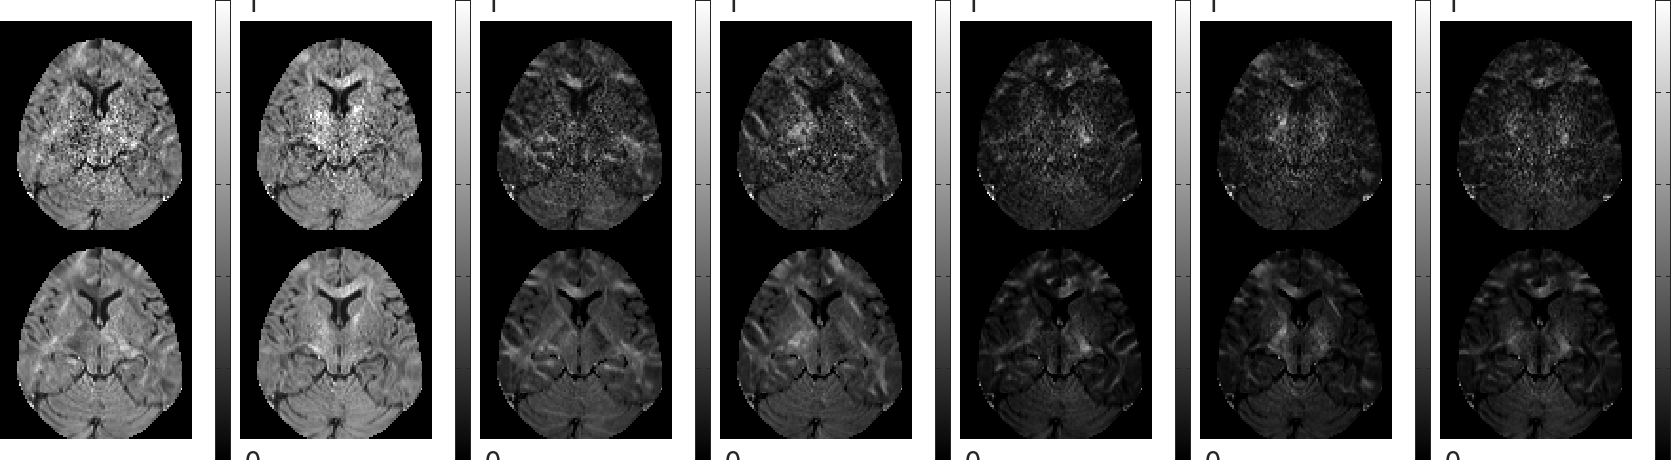

In [8]:
tic;
atti2 = mapl2atti( mapl, dti, gi, bi, 'mask', mask );
fprintf(1,'It took %1.3f seconds to predict the attenuation signal\n',toc);
channels = [13,51,109,121,182,213,247];
close(figure(2)); % Close previous figures if needed
hf = figure(2);
set(hf,'Name','Original DWIs vs. reconstructed DWIs','Position',[10,10,1680,460]);
R=1; C=7;
% --
r=1; c=1; ch = channels(c);
subplot('Position',[(c-1)/C,(r-1)/R,1/C,1/R]);
imshow([(double(mask(:,:,slc(1))).*atti(:,:,slc(1),ch))';atti2(:,:,slc(1),ch)'],[0,1.0]);
colormap(gray); colorbar;
axis('equal');axis('off');axis('tight');
% --
r=1; c=2; ch = channels(c);
subplot('Position',[(c-1)/C,(r-1)/R,1/C,1/R]);
imshow([(double(mask(:,:,slc(1))).*atti(:,:,slc(1),ch))';atti2(:,:,slc(1),ch)'],[0,1.0]);
colormap(gray); colorbar;
axis('equal');axis('off');axis('tight');
% --
r=1; c=3; ch = channels(c);
subplot('Position',[(c-1)/C,(r-1)/R,1/C,1/R]);
imshow([(double(mask(:,:,slc(1))).*atti(:,:,slc(1),ch))';atti2(:,:,slc(1),ch)'],[0,1.0]);
colormap(gray); colorbar;
axis('equal');axis('off');axis('tight');
% --
r=1; c=4; ch = channels(c);
subplot('Position',[(c-1)/C,(r-1)/R,1/C,1/R]);
imshow([(double(mask(:,:,slc(1))).*atti(:,:,slc(1),ch))';atti2(:,:,slc(1),ch)'],[0,1.0]);
colormap(gray); colorbar;
axis('equal');axis('off');axis('tight');
% --
r=1; c=5; ch = channels(c);
subplot('Position',[(c-1)/C,(r-1)/R,1/C,1/R]);
imshow([(double(mask(:,:,slc(1))).*atti(:,:,slc(1),ch))';atti2(:,:,slc(1),ch)'],[0,1.0]);
colormap(gray); colorbar;
axis('equal');axis('off');axis('tight');
% --
r=1; c=6; ch = channels(c);
subplot('Position',[(c-1)/C,(r-1)/R,1/C,1/R]);
imshow([(double(mask(:,:,slc(1))).*atti(:,:,slc(1),ch))';atti2(:,:,slc(1),ch)'],[0,1.0]);
colormap(gray); colorbar;
axis('equal');axis('off');axis('tight');
% --
r=1; c=7; ch = channels(c);
subplot('Position',[(c-1)/C,(r-1)/R,1/C,1/R]);
imshow([(double(mask(:,:,slc(1))).*atti(:,:,slc(1),ch))';atti2(:,:,slc(1),ch)'],[0,1.0]);
colormap(gray); colorbar;
axis('equal');axis('off');axis('tight');
% --

## Prepare 3\-D renderings

This is only to have  a DTI\-based reference to plot color\-by\-orientation and FA as a background for the glyphs:


In [9]:
[~,~,~,lb1,lb2,lb3] = dti2spectrum(dti,'mask',mask);
FA = spectrum2scalar( lb1, lb2, lb3, 'mask', mask, 'scalar', 'fa' );
FATH = 0.2;
% Convert tensor representation to SH representation to use it
% with the plot function:
shbg = hot2sh( dti, 'mask', mask );

## EAP reconstruction and representation

The MAP\-MRI coefficients can be used to recover the Ensemble Average Propagator as well for arbitrary points in the R\-space described in spherical coordinates. For the purpose of this demo, we will choose a fixed distance from the origin and compute the value of the EAP in a densely sampled sphere with this radius. This way, we will get a spherical diffusion profile with information similar (but not equivalent) to that provided by ODF fields.


Define first this spherical sampling:


In [10]:
N = 128;                 % Number of sampled directions within (half) a sphere
ui = designGradients(N); % Nx3 sampling
R = 0.015;               % Distance from the origin, in millimeters
ri = R*ones(N,1);


Now we can just make a call to the toolbox function that computes the EAP:


In [11]:
eap = mapl2eap(mapl,dti,ui,ri,'mask',mask,'tau',tau);


Note this volume contains just a ser of values within a regular spherical grid. To represent the diffusion profile using the toolbox function, however, we need a Spherical Harmonics volume. We can get it from the dense spherical representation as:


In [12]:
sh = signal2sh(eap,ui,'L',8,'lambda',1e-4,'mask',mask);


And it only remains to plot the results in the usual way:


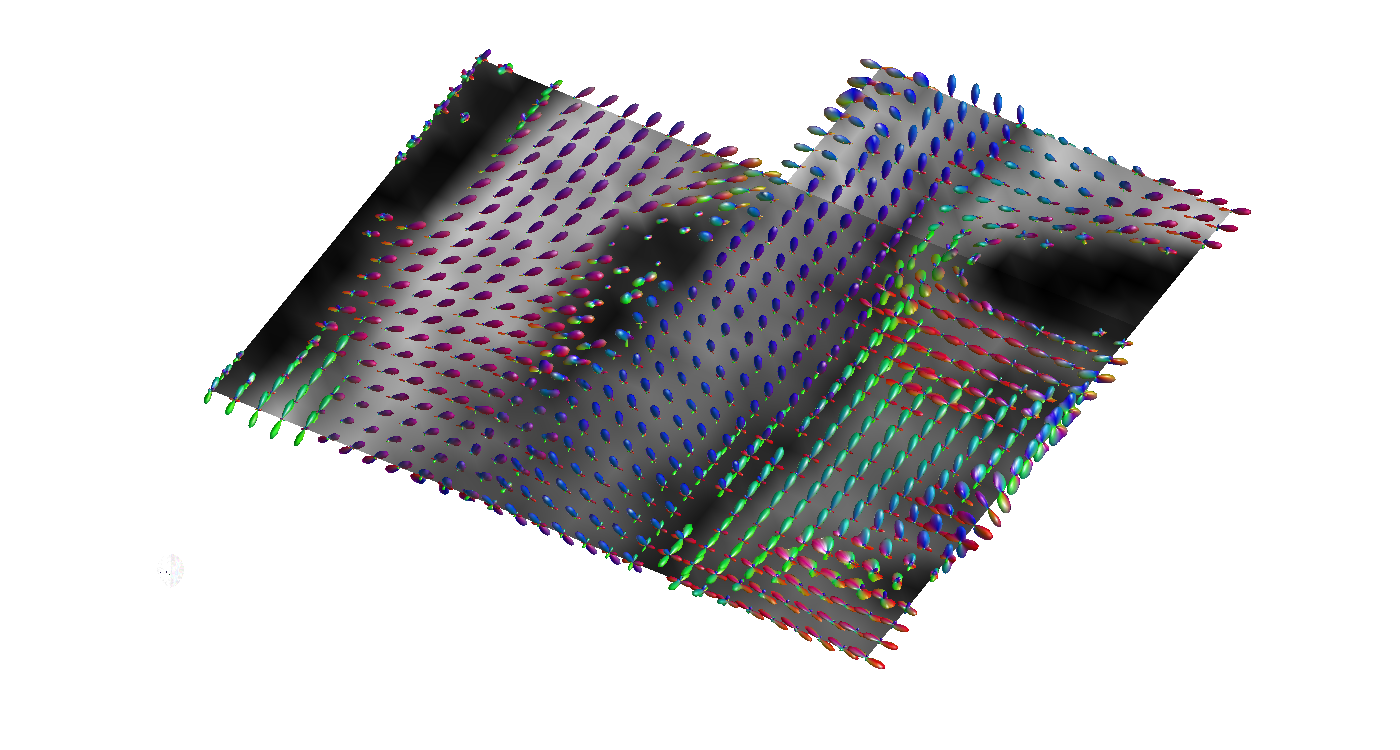

In [13]:
close(figure(3)); % Close previous figures if necessary
hf  = figure(3);
set(hf,'Name','Spherical diffusion profiles','Position',[10,10,1400,750]);
%---------------------------------------------------------------------------------------------------
contrast = [];
%---------------------------------------------------------------------------------------------------
ha1 = axes('Parent',hf);
set(ha1,'OuterPosition',[-0.02,-0.03,0.25,0.5]);
sl = 3; mx = 53; % Select the piece of data to plot with our cool plotdmri3d
plotdmri3d(sh,[1,mx],[1,110],[sl,sl],'bgimage', 'color', 'bgsh', shbg, 'ha', ...
    ha1, 'bgalpha', 1, 'mask', mask, 'bbox', false, 'glyphs', false, 'origin', ...
    [0;0;0],'direction',eye(3),'space','LPS','mframe',eye(3) ); % color-by-orientation half the slice
plotdmri3d(sh,[mx,101],[1,110],[sl,sl],'bgimage', 'fa', 'bgsh', shbg, 'ha', ...
    ha1,'bgalpha', 1, 'mask', mask, 'bbox', false, 'glyphs', false, 'origin', ...
    [0;0;0],'direction',eye(3),'space','LPS','mframe',eye(3)  ); % FA image for the other half of the slice
plotdmri3d(sh,[mx+2,mx+30],[45,65],[sl,sl],'ha',ha1, 'bgimage', 'fa', 'bgsh', ...
    shbg, 'bgalpha', 1, 'mask', mask & (FA>FATH), 'bbox', false, 'glyphs', true, 'angleres', ...
    642, 'contrast', contrast, 'glyphspc', [1;1;1], 'glyphsc', 1.5,'glyphscvar', 'none', 'origin', ...
    [0;0;0],'direction',eye(3),'space','LPS','mframe',eye(3)  ); % Cool ODF glyphs in the CC and CG
plotdmri3d(sh,[mx+15,mx+30],[66,72],[sl,sl],'ha',ha1, 'bgimage', 'fa', 'bgsh', ...
    shbg, 'bgalpha', 1, 'mask', mask & (FA>FATH), 'bbox', false, 'glyphs', true, 'angleres', ...
    642, 'contrast', contrast, 'glyphspc', [1;1;1], 'glyphsc', 1.5,'glyphscvar', 'none', 'origin', ...
    [0;0;0],'direction',eye(3),'space','LPS','mframe',eye(3)  ); % Cool ODF glyphs in the CC and CG
light('Position',[-1,0,-1]); % Even cooler look
axis('equal');
axis('off');
view(ha1,0,270);
%zoom(1.01);
ha3 = axes('Parent',hf);
set(ha3,'OuterPosition',[-0.6,-0.525,2.2,2.2]);
sl = 3; mx = 53; % Select the piece of data to plot with our cool plotdmri3d
plotdmri3d(sh,[mx+2,mx+30],[45,65],[sl,sl],'bgimage', 'fa', 'bgsh', shbg, 'ha', ...
    ha3,'bgalpha', 1, 'mask', mask, 'bbox', false, 'glyphs', false, 'origin', ...
    [0;0;0],'direction',eye(3),'space','LPS','mframe',eye(3)  );
plotdmri3d(sh,[mx+2,mx+30],[45,65],[sl,sl],'ha',ha3, 'bgimage', 'fa', 'bgsh', ...
    shbg, 'bgalpha', 0, 'mask', mask & (FA>FATH), 'bbox', false, 'glyphs', true, 'angleres', ...
    642, 'contrast', contrast, 'glyphspc', [1;1;1], 'glyphsc', 1,'glyphscvar', 'ga', 'origin', ...
    [0;0;0],'direction',eye(3),'space','LPS','mframe',eye(3)  ); % Cool ODF glyphs in the CC and CG
plotdmri3d(sh,[mx+15,mx+30],[65,72],[sl,sl],'bgimage', 'fa', 'bgsh', shbg, 'ha', ...
    ha3,'bgalpha', 1, 'mask', mask, 'bbox', false, 'glyphs', false, 'origin', ...
    [0;0;0],'direction',eye(3),'space','LPS','mframe',eye(3)  );
plotdmri3d(sh,[mx+15,mx+30],[66,72],[sl,sl],'ha',ha3, 'bgimage', 'fa', 'bgsh', ...
    shbg, 'bgalpha', 0, 'mask', mask & (FA>FATH), 'bbox', false, 'glyphs', true, 'angleres', ...
    642, 'contrast', contrast, 'glyphspc', [1;1;1], 'glyphsc', 1,'glyphscvar', 'ga', 'origin', ...
    [0;0;0],'direction',eye(3),'space','LPS','mframe',eye(3)  ); % Cool ODF glyphs in the CC and CG
light('Position',[1,0,1]); % Even cooler look
axis('equal');
axis('off');
view(ha3,30,45);

## Computation of Orientation Ditribution Functions (ODFs)

The values of the ODF can be analytically retrieved for any arbitrary set of unit\-directions from the MAPL coefficients. We will use the same set "ui" designed in the previous section, so that it suffices to call the corresponding function (you can play with the "contrast" parameter \-always use values greater than \-1\- and check  the results; the default value of 2.0 provides the actual probabilistic ODFs):


In [14]:
odf = mapl2odf(mapl,dti,ui,'mask',mask,'tau',tau,'contrast',2);


Note the regular way in which ODFs are represented is through Spherical Harmonics (SH) representations (and this is the input taken by our plot function, too). Unfortunately, there is not a trivial analytical relationship between the (anisotropic) MAPL coefficients of the EAP and the SH coefficients of the ODF, so that we must fit these coefficients numerically. Let's make it:


In [15]:
sh2 = signal2sh(odf,ui,'L',8,'lambda',1e-4,'mask',mask);


And now we can use these sh2 to get the plots:


In [ ]:
close(figure(4)); % Close previous figures if necessary
hf  = figure(4);
set(hf,'Name','Spherical diffusion profiles','Position',[10,10,1400,750]);
%---------------------------------------------------------------------------------------------------
contrast = [];
%---------------------------------------------------------------------------------------------------
ha1 = axes('Parent',hf);
set(ha1,'OuterPosition',[-0.02,-0.03,0.25,0.5]);
sl = 3; mx = 53; % Select the piece of data to plot with our cool plotdmri3d
plotdmri3d(sh2,[1,mx],[1,110],[sl,sl],'bgimage', 'color', 'bgsh', shbg, 'ha', ...
    ha1, 'bgalpha', 1, 'mask', mask, 'bbox', false, 'glyphs', false, 'origin', ...
    [0;0;0],'direction',eye(3),'space','LPS','mframe',eye(3) ); % color-by-orientation half the slice
plotdmri3d(sh2,[mx,101],[1,110],[sl,sl],'bgimage', 'fa', 'bgsh', shbg, 'ha', ...
    ha1,'bgalpha', 1, 'mask', mask, 'bbox', false, 'glyphs', false, 'origin', ...
    [0;0;0],'direction',eye(3),'space','LPS','mframe',eye(3)  ); % FA image for the other half of the slice
plotdmri3d(sh2,[mx+2,mx+30],[45,65],[sl,sl],'ha',ha1, 'bgimage', 'fa', 'bgsh', ...
    shbg, 'bgalpha', 0, 'mask', mask & (FA>FATH), 'bbox', false, 'glyphs', true, 'angleres', ...
    642, 'contrast', contrast, 'glyphspc', [1;1;1], 'glyphsc', 1.5,'glyphscvar', 'none', 'origin', ...
    [0;0;0],'direction',eye(3),'space','LPS','mframe',eye(3)  ); % Cool ODF glyphs in the CC and CG
plotdmri3d(sh2,[mx+15,mx+30],[66,72],[sl,sl],'ha',ha1, 'bgimage', 'fa', 'bgsh', ...
    shbg, 'bgalpha', 0, 'mask', mask & (FA>FATH), 'bbox', false, 'glyphs', true, 'angleres', ...
    642, 'contrast', contrast, 'glyphspc', [1;1;1], 'glyphsc', 1.5,'glyphscvar', 'none', 'origin', ...
    [0;0;0],'direction',eye(3),'space','LPS','mframe',eye(3)  ); % Cool ODF glyphs in the CC and CG
light('Position',[-1,0,-1]); % Even cooler look
axis('equal');
axis('off');
view(ha1,0,270);
%zoom(1.01);
ha3 = axes('Parent',hf);
set(ha3,'OuterPosition',[-0.6,-0.525,2.2,2.2]);
sl = 3; mx = 53; % Select the piece of data to plot with our cool plotdmri3d
plotdmri3d(sh2,[mx+2,mx+30],[45,65],[sl,sl],'bgimage', 'fa', 'bgsh', shbg, 'ha', ...
    ha3,'bgalpha', 1, 'mask', mask, 'bbox', false, 'glyphs', false, 'origin', ...
    [0;0;0],'direction',eye(3),'space','LPS','mframe',eye(3)  ); % FA image for the other half of the slice
plotdmri3d(sh2,[mx+2,mx+30],[45,65],[sl,sl],'ha',ha3, 'bgimage', 'fa', 'bgsh', ...
    shbg, 'bgalpha', 0, 'mask', mask & (FA>FATH), 'bbox', false, 'glyphs', true, 'angleres', ...
    642, 'contrast', contrast, 'glyphspc', [1;1;1], 'glyphsc', 1,'glyphscvar', 'ga', 'origin', ...
    [0;0;0],'direction',eye(3),'space','LPS','mframe',eye(3)  ); % Cool ODF glyphs in the CC and CG
plotdmri3d(sh2,[mx+15,mx+30],[65,72],[sl,sl],'bgimage', 'fa', 'bgsh', shbg, 'ha', ...
    ha3,'bgalpha', 1, 'mask', mask, 'bbox', false, 'glyphs', false, 'origin', ...
    [0;0;0],'direction',eye(3),'space','LPS','mframe',eye(3)  ); % FA image for the other half of the slice
plotdmri3d(sh2,[mx+15,mx+30],[66,72],[sl,sl],'ha',ha3, 'bgimage', 'fa', 'bgsh', ...
    shbg, 'bgalpha', 0, 'mask', mask & (FA>FATH), 'bbox', false, 'glyphs', true, 'angleres', ...
    642, 'contrast', contrast, 'glyphspc', [1;1;1], 'glyphsc', 1,'glyphscvar', 'ga', 'origin', ...
    [0;0;0],'direction',eye(3),'space','LPS','mframe',eye(3)  ); % Cool ODF glyphs in the CC and CG
light('Position',[1,0,1]); % Even cooler look
axis('equal');
axis('off');
view(ha3,30,45);